# Exp 016: Analyze Performance in Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import random

import sys
sys.path.append("../source")
import importlib
#importlib.reload(helpers)
from helpers import format_context, egp, get_prompt_task_2, get_preferred_nrs
from evaluation import calculate_distinct_n

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.57263013.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_constraints_neg': ['mean']} if 'num_constraints_neg' in results.columns else {}
    aggs = results.groupby(by).agg({'num_constraints_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in ['Appropriateness',
                                                                          'Relevance',
                                                                          'Content Richness',
                                                                          'Grammatical Correctness']}})
    return aggs

def plot_sat(res, col='num_constraints_sat', by='num_constraints', xlabel="Number of constraints", title="Relative amount of satisfied constraints"):
    get_aggs(res, ["model", by]).unstack(level=0)[col]['mean'].plot(kind='bar')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel("Success Rate")
    plt.xlabel(xlabel)
    plt.ylim(0,1)
    plt.title(title)
    plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        ax.annotate(txt, (x.iloc[i]+0.01, y.iloc[i]-0.02))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

# Task 1

In [49]:
models = ["gpt35", "llama", "llama-FT-multi", "llama-decoding"]#, "llama-FT-decoding"
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task1/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]
    results['responses0'] = results['responses'].apply(lambda x: x[0])
    results['num_constraints'] = results['constraints'].apply(len)
    results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
    res = pd.concat([res, results])

single_constraints = res[res['num_constraints']==1].copy()
single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])

## Qualitative evaluation

Pick a random test case and print answers from all models

In [45]:
case = res.loc[random.randint(0, max(res.index))]
print("=== DIALOG ===")
print(format_context(case.iloc[0]['context']))
constraints = case.iloc[0]['constraints']
print("=== CONSTRAINTS ===")
for statement in egp[egp['#'].isin(constraints)]['Can-do statement']:
    print(statement)
print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses0']} ({responses.iloc[0]['num_constraints_sat']:.1%})")

=== DIALOG ===
A: ya I watch it sometimes, I read the site ign.com every day for videogame stuff, and they are apparently owned by fox news
B: I wonder how many other channels are owned by them. They even considered making a channel that would only play episodes of the Simpsons
A: haha Id watch that, weird though that fox news co-creator was Richard Nixon, didn't know that
B: And the other creator was a Republican media strategist. Was Nixon still President at the time it was created? 
=== CONSTRAINTS ===
Can use the irregular superlative adjective 'best' in the phrase 'my best friend'.
Can form a limited range of complex noun phrases with a superlative adjective  + prepositional phrase, to talk about something unique.► noun phrases ►  clauses: comparison
Can use 'would' with a wide range of verbs to talk about wishes and preferences.
Can use 'would' to talk about habitual actions and events in the past.
Can use negative question forms in main clauses and question tags. ► questions
Can

## Quantitative Evaluation

In [104]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness        \
                                           mean count            mean count   
model          response_hit                                                   
gpt35          0.0                     0.507586   725        3.638889    36   
               1.0                     0.612414   725        3.710526    38   
llama          0.0                     0.606897   725        3.275862    29   
               1.0                     0.615172   725        3.452381    42   
llama-FT-multi 0.0                     0.659310   725             NaN     0   
               1.0                     0.758621   725             NaN     0   
llama-decoding 0.0                     0.835862   725             NaN     0   
               1.0                     0.823448   725             NaN     0   

                            Relevance       Content Richness        \
                                 mean count             mean count   
model          response_hit                                          
gpt35          0.0           3.361111    36         3.166667    36   
               1.0           3.710526    38         3.210526    38   
llama          0.0           2.896552    29         2.689655    29   
               1.0           3.142857    42         3.000000    42   
llama-FT-multi 0.0                NaN     0              NaN     0   
               1.0                NaN     0              NaN     0   
llama-decoding 0.0                NaN     0              NaN     0   
               1.0                NaN     0              NaN     0   

                            Grammatical Correctness        
                                               mean count  
model          response_hit                                
gpt35          0.0                         4.944444    36  
               1.0                         5.000000    38  
llama          0.0                         5.000000    29  
               1.0                         4.880952    42  
llama-FT-multi 0.0                              NaN     0  
               1.0                              NaN     0  
llama-decoding 0.0                              NaN     0  
               1.0                              NaN     0

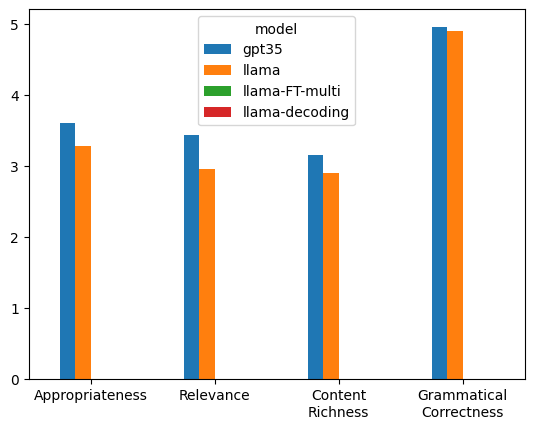

In [82]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

<Axes: >

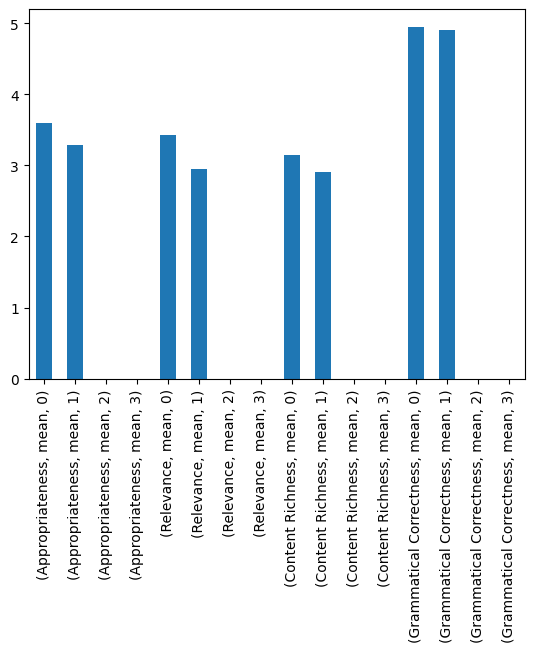

In [58]:
df.unstack(level=0)

In [25]:
def get_mean_distinct(model):
    return get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True)['responses0']['calculate_distinct_n'].mean()
print()

{'gpt35': 0.7168945066605081, 'llama': 0.6606024349941949, 'llama-FT-multi': 0.6118917919285612, 'llama-decoding': 0.64560400067652}


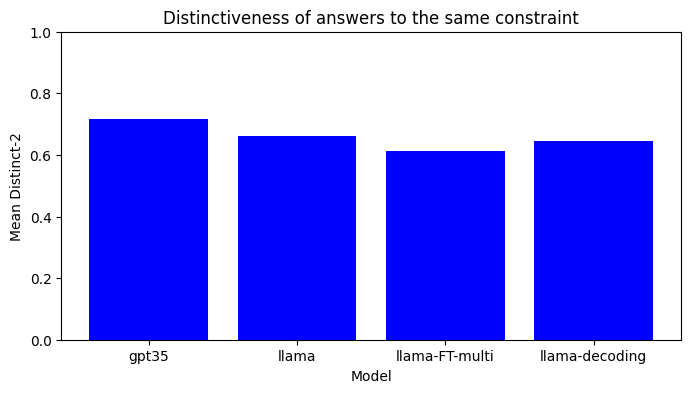

In [29]:
plt.figure(figsize=(8, 4))
plt.bar(models, [get_mean_distinct(model) for model in models], color='blue')
plt.xlabel('Model')
plt.ylabel('Mean Distinct-2')
plt.ylim(0,1)
plt.title('Distinctiveness of answers to the same constraint')
plt.show()

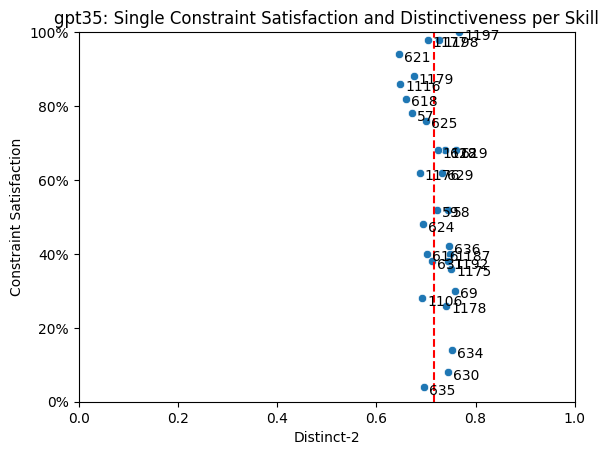

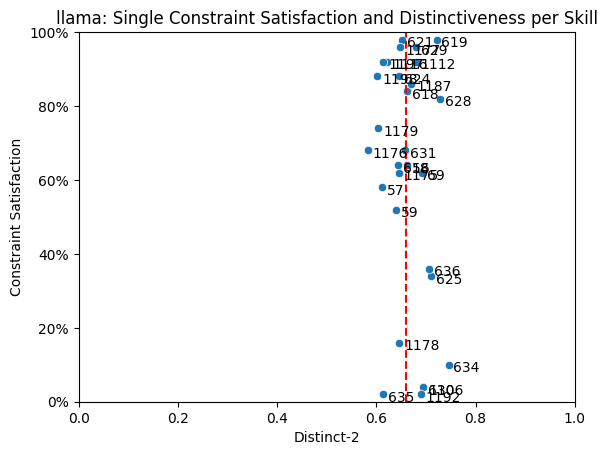

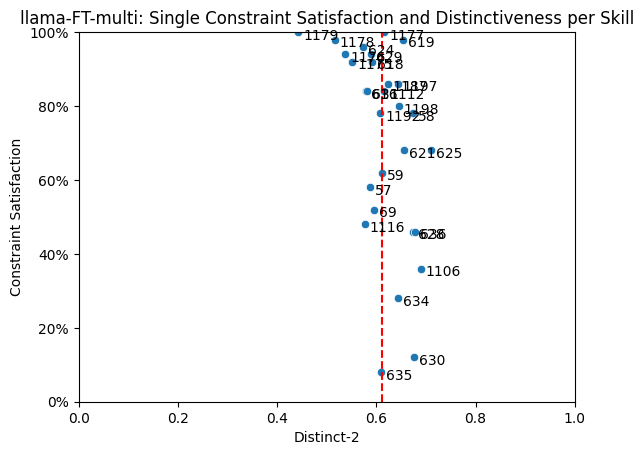

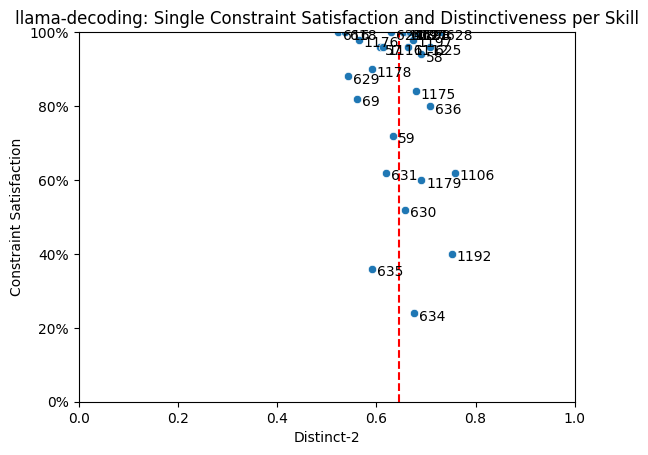

In [30]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

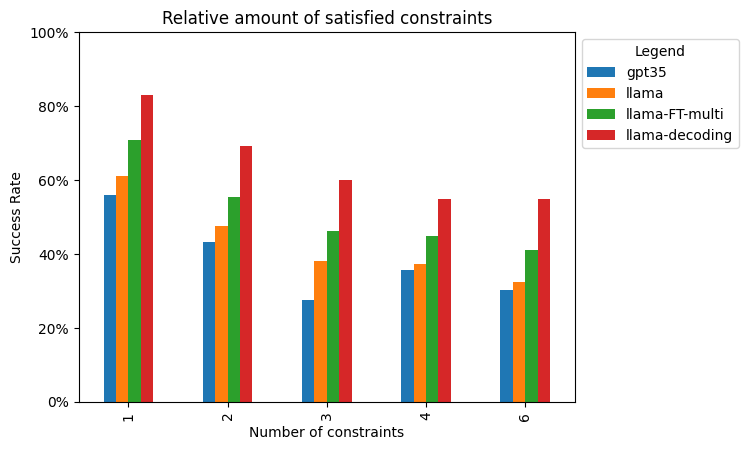

In [35]:
plot_sat(res)

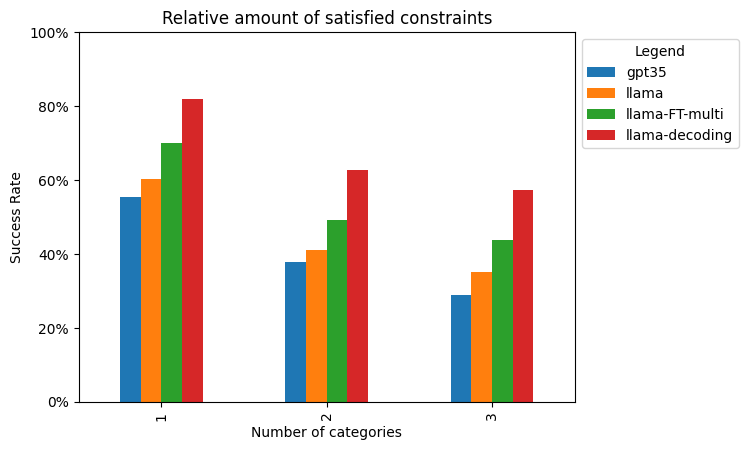

In [38]:
plot_sat(res, by="n_subcats", xlabel="Number of categories")

# Task 2

In [83]:
def categories_satisfied(row, type='positive'):
    df = pd.DataFrame({'score': row[f'{type}_constraints'], 'category': row[f'{type}_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)>0})['score'])

In [84]:
models = ["gpt35", "llama", "llama-FT-task1", "llama-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task2/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['num_constraints'] = results['categories'].apply(len)
    results['num_constraints_sat'] = results.apply(categories_satisfied, axis=1)
    results['num_constraints_neg'] = results.apply(categories_satisfied, axis=1, args=['negative'])
    res = pd.concat([res, results])

## Qualitative Evaluation

In [92]:
case = res.loc[random.randint(0, max(res.index))]
msg = get_prompt_task_2(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['num_constraints_sat']:.0%}/{responses.iloc[0]['num_constraints_neg']:.0%})")

Given the dialog, write a possible next turn of A that preferably use the following grammar patterns in the response:
- would on CEFR level A1 (FORM: AFFIRMATIVE WITH 'LIKE'; USE: WISHES AND PREFERENCES WITH 'LIKE')
- negation on CEFR level B1 (FORM: QUESTIONS)
- superlatives on CEFR level A2 (FORM/USE: COMPLEX NOUN PHRASES; FORM/USE: WITH 'IN' + NOUN)
Dialog:
A: yes I do. do you have a favorite player?
B: No, I do not, though I know that Tom Brad is a great player. I know that's attributed to his skill but is also partially diet. He has never eaten a strawberry.
A: that is strange. I wonder if he is jealous or what?
B: Speaking of jealous, I wonder if he is jealous of his wife as she makes more than double her husband's salary.

=== RESPONSES ===
Model: gpt35
A: I would like to know if he is jealous of his wife's salary. (33%/12%)
Model: llama
I would like to know more about Tom Brad's diet, like what he eats in a day. (33%/12%)
Model: llama-FT-task1
I would like to be her husband. I 

## Quantitative evaluation

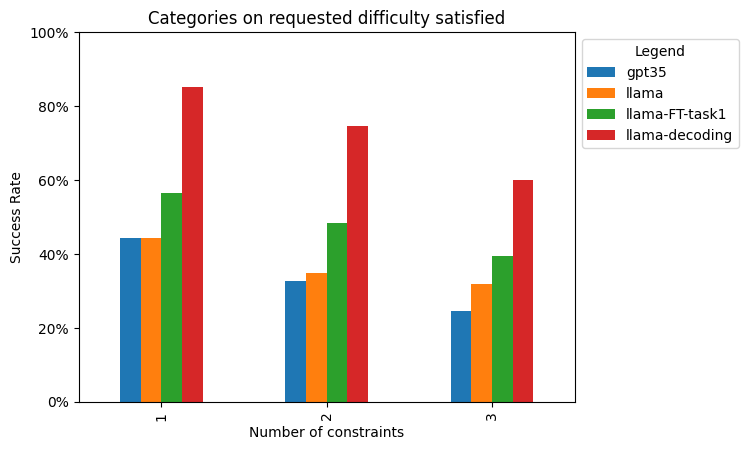

In [98]:
plot_sat(res, title="Categories on requested difficulty satisfied")

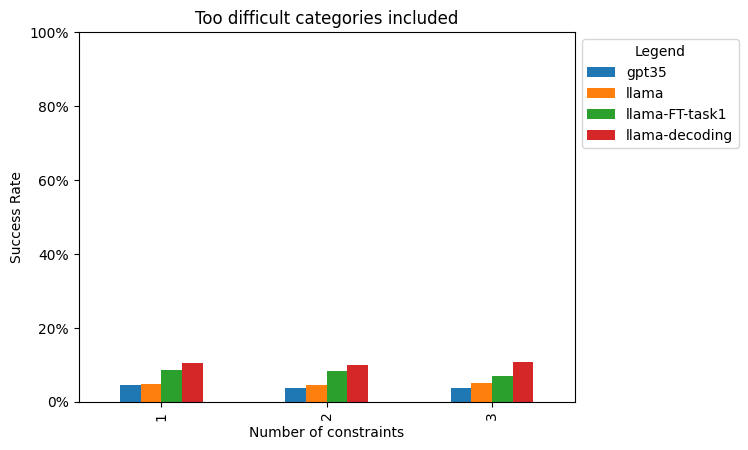

In [99]:
plot_sat(res, 'num_constraints_neg', title="Too difficult categories included")